<a href="https://colab.research.google.com/github/ErickArciniega/SimpsonsRNC/blob/master/Simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNC-Springfield
### Red Neuronal Convolucional de personajes de los Simpson
 Se hara el preprocesamiento y arquitectura de una RNC con personajes de los simpson, así como la implementación de Tensorboard para monitorear el comportamiento de la RNC.

 Dataset obtenido de: https://www.kaggle.com/jfgm2018/the-simpsons-dataset-compilation-49-characters

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from random import sample
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from skimage import filters, exposure, color
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Descargamos el dataset de github

In [2]:
! git clone https://github.com/ErickArciniega/SimpsonsRNC.git

Cloning into 'SimpsonsRNC'...
remote: Enumerating objects: 33685, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 33685 (delta 1), reused 8 (delta 1), pack-reused 33677
Receiving objects: 100% (33685/33685), 787.00 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (324/324), done.
Checking out files: 100% (34580/34580), done.


In [3]:
TRAINING_PATH = 'SimpsonsRNC/data/simpsons_dataset/'
TEST_PATH = 'SimpsonsRNC/data/simpsons_testdataset/'

paths = ['bart_simpson/',
         'lenny_leonard/',
         'lisa_simpson/',
         'marge_simpson/',
         'maggie_simpson/',
         'milhouse_van_houten/',
         'moe_szyslak/',
         'nelson_muntz/',
         'comic_book_guy/',
         'otto_mann/',
         'disco_stu/',
         'apu_nahasapeemapetilon/',
         'abraham_grampa_simpson/']

Por las limitantes tecnicas se escogieron 14 personajes 



*   Bart
*   Lenny
*   Lisa
*   Marge
*   Maggie
*   Milhouse
*   Moe
*   Nelson
*   Jeff(El de los comics)
*   Otto
*   Disco Stu
*   Apu
*   Abuelo simpson

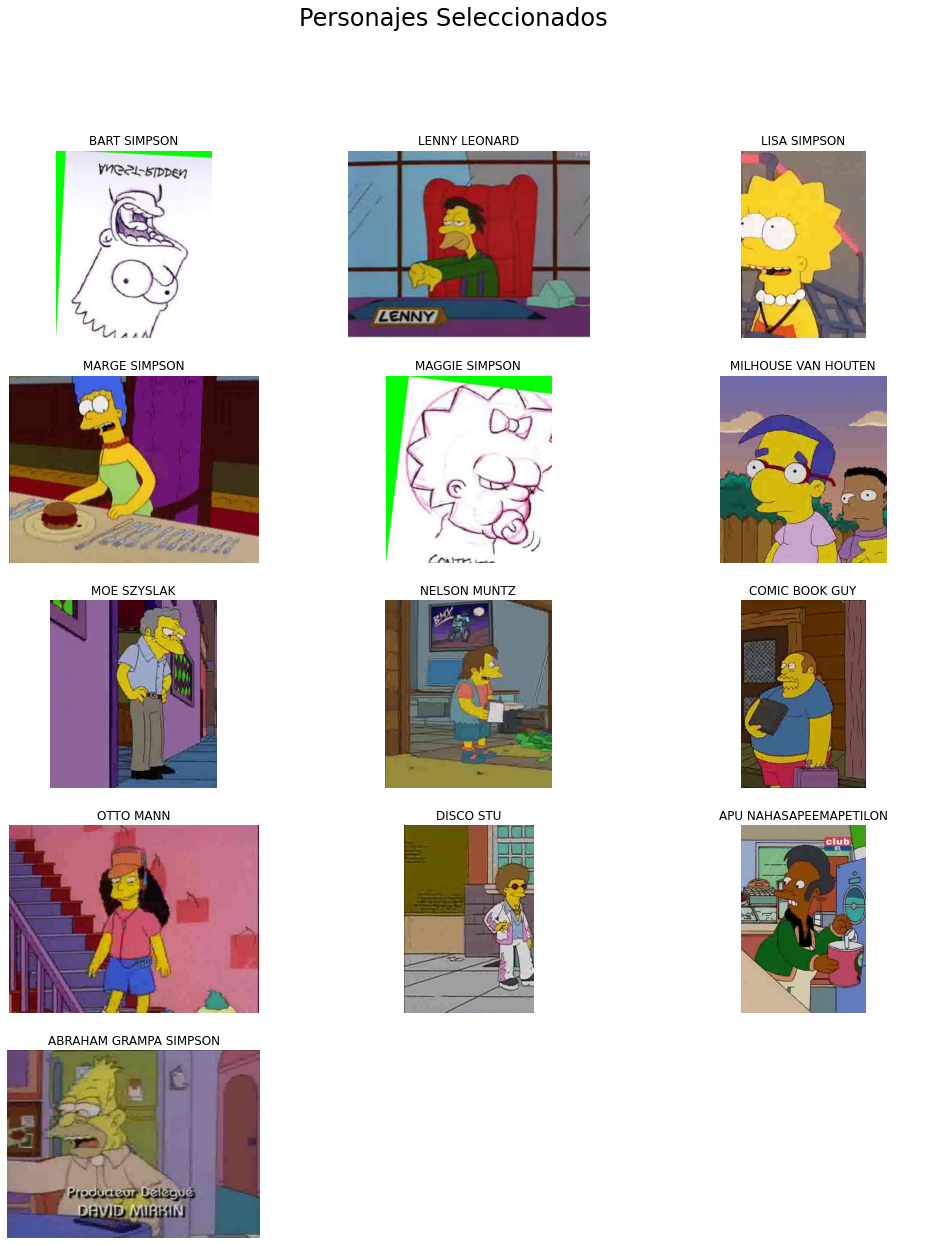

In [6]:
ROWS = 5
COLS = 3 
path = 0

amount_images = np.zeros(len(paths))

fig, ax = plt.subplots(5, 3, figsize = (17, 20) )
fig.suptitle('Personajes Seleccionados',fontsize=24)

for i in range(ROWS):
    for j in range(COLS):
        pics = os.listdir(TRAINING_PATH + paths[path])
        amount_images[path] = len(pics)
        index = np.random.randint(len(pics))
        ax[i][j].imshow(Image.open(TRAINING_PATH + paths[path] + pics[index]))
        ax[i][j].axis('off')
        ax[i][j].set_title(' '.join(paths[path].split('_')).replace('/', '').upper())
        path += 1

        if (path > 12):
            break

ax[4][2].axis('off')
ax[4][1].axis('off')
plt.show()


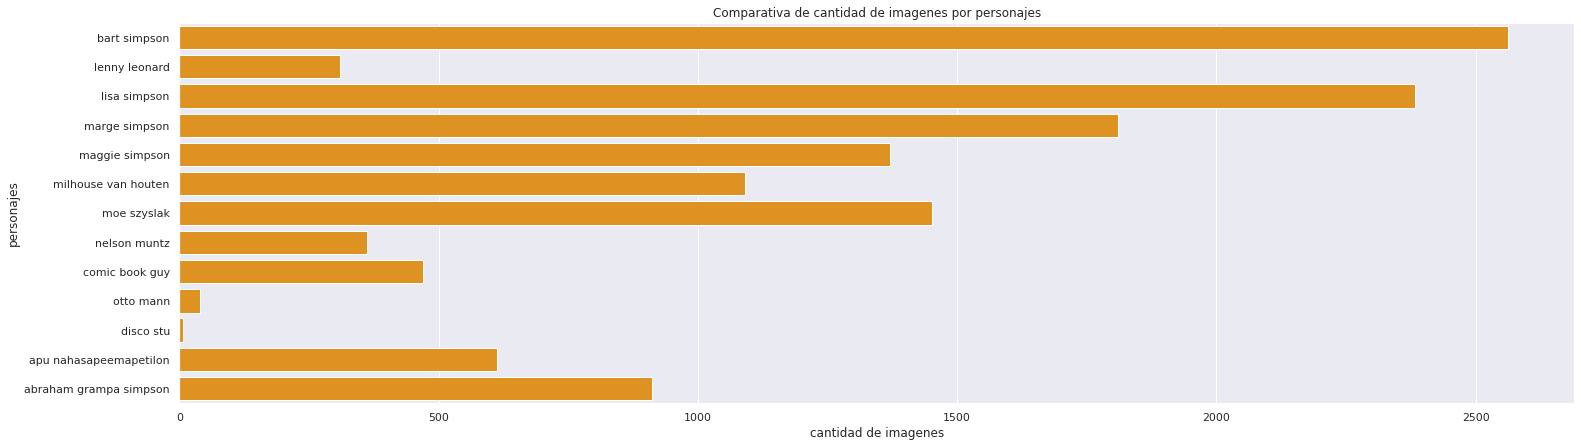

In [7]:
data = {
    'personajes' : [' '.join(path.split('_')).replace('/', '') for path in paths],
    'cantidad de imagenes' : amount_images
}
df = pd.DataFrame(data)
sns.set(style="darkgrid")
plt.figure(figsize=(25, 7))

sns.barplot(
    x = 'cantidad de imagenes', 
    y = 'personajes',
    data = df, 
    estimator = sum, 
    ci = None, 
    color = '#fc9803').set_title('Comparativa de cantidad de imagenes por personajes');

plt.savefig('graficaComparativa', bbox_inches = 'tight')

Como se puede observar el dataset cuenta con un problema de desbalanceo, lo podemos ver con los personajes que elegimos dado que bart tiene poco mas de 2500 imagenes y otros personajes como disco stu cuentan con menos de 100 imagenes, lo ideal seria conseguir mas imagenes de los personajes que estan desbalanceados o en su defecto eliminar imagenes de los personajes con mas imagenes, en este caso realizaremos lo segundo, disminuyendo las imagenes de marge, lisa y bart hasta menos de 2000 imagenes

In [9]:
#Funcion para borrar el excedente de imagenes
def eraseImages(character, imagesAmount ):
  originImages = os.listdir(TRAINING_PATH + paths[character])
  deleteAmount = len(originImages) - imagesAmount
  imagesToDelete = sample(originImages, deleteAmount) #Para hacer que las imagenes a borrar sean random

  for img in imagesToDelete:
    os.remove(TRAINING_PATH + paths[character] + img)

  amount_images[character] = len(os.listdir(TRAINING_PATH + paths[character]))



In [17]:
#Implementacion de la funcion anterior
eraseImages(0, 1300)  #Bart
eraseImages(2, 1300)  #Lisa
eraseImages(3, 1300)  #marge
eraseImages(6, 1300)  #moe

In [18]:
print(len(os.listdir(TRAINING_PATH + paths[0])))

1300


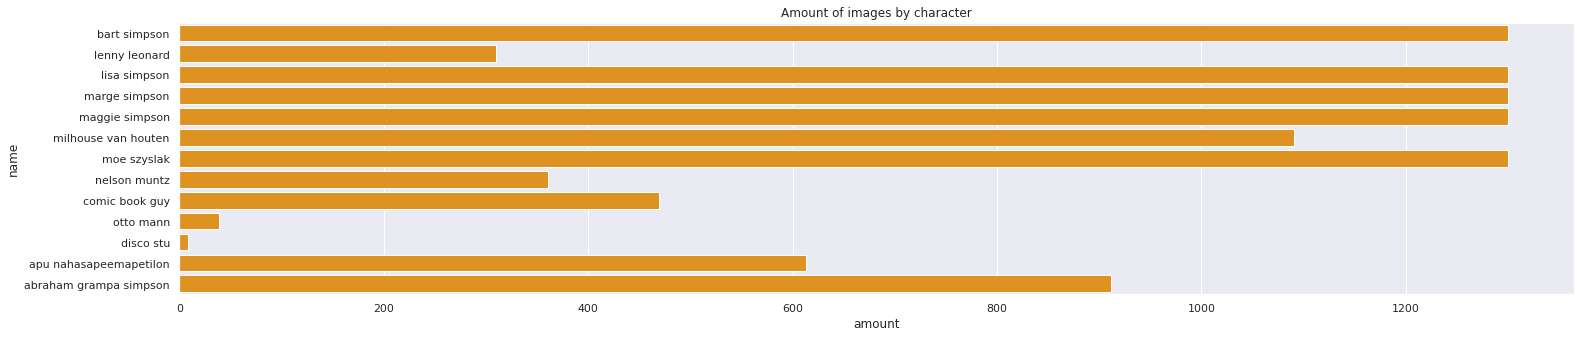

In [19]:

data = {
    'name' : [' '.join(path.split('_')).replace('/', '') for path in paths],
    'amount' : amount_images
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(25, 5))

sns.barplot(
    x = 'amount', 
    y = 'name', 
    data = df, 
    estimator = sum, 
    ci = None, 
    color = '#fc9803').set_title('Amount of images by character');

plt.savefig('graficaComparativa2', bbox_inches = 'tight')

Como podemos observar nuestro dataset ya se encuentra más balanceado después de eliminar algunas imagenes de los personajes con mayor cantidad de ellas.

Dado que el dataset puede contener imagenes en distintos canales (RGB,CMYK,...) y formatos, como podemos ver a continuacion.

In [20]:
trainChanels = []
testChanels = []
testCMYKImages = []

for path in paths:
  trainImg = os.listdir(TRAINING_PATH + path)
  testImg = os.listdir(TEST_PATH + path)

  for img in trainImg:
    trainImgChanel = np.asarray(Image.open(TRAINING_PATH + path + img)).shape
    if (len(trainImgChanel) > 2):
      trainImgChanel = trainImgChanel[-1]
    else:
      trainImgChanel = 2
    if (trainImgChanel not in trainChanels):
      trainChanels.append(trainImgChanel)
  
  print('Analizando: ' + path)
  
  for img in testImg:
    testImgChanel = np.asarray(Image.open(TEST_PATH + path + img)).shape
    if (len(testImgChanel)>2):
      testImgChanel = testImgChanel[-1]

      if testImgChanel == 4:
        testCMYKImages.append(path + img)


    else:
      testImgChanel =2
    if (testImgChanel not in testChanels):
      testChanels.append(testImgChanel)

print('\nCanales en imagenes de entrenamiento: ', trainChanels)
print('Canales en imagenes de prueba: ', testChanels)

Analizando: bart_simpson/
Analizando: lenny_leonard/
Analizando: lisa_simpson/
Analizando: marge_simpson/
Analizando: maggie_simpson/
Analizando: milhouse_van_houten/
Analizando: moe_szyslak/
Analizando: nelson_muntz/
Analizando: comic_book_guy/
Analizando: otto_mann/
Analizando: disco_stu/
Analizando: apu_nahasapeemapetilon/
Analizando: abraham_grampa_simpson/

Canales en imagenes de entrenamiento:  [3]
Canales en imagenes de prueba:  [3]


Dado que la mayoria de nuestras imagenes estan en rgb es necesario convertirlas a escala de grises, como podemos ver a continuacion una imagen rgb se compone de 3 capas (Rojo, Verde y Azul), esto lo podremos ver tomando una imagen de bart aleatoriamente y viendo sus 3 capas de color.

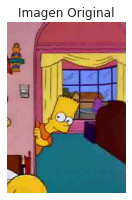

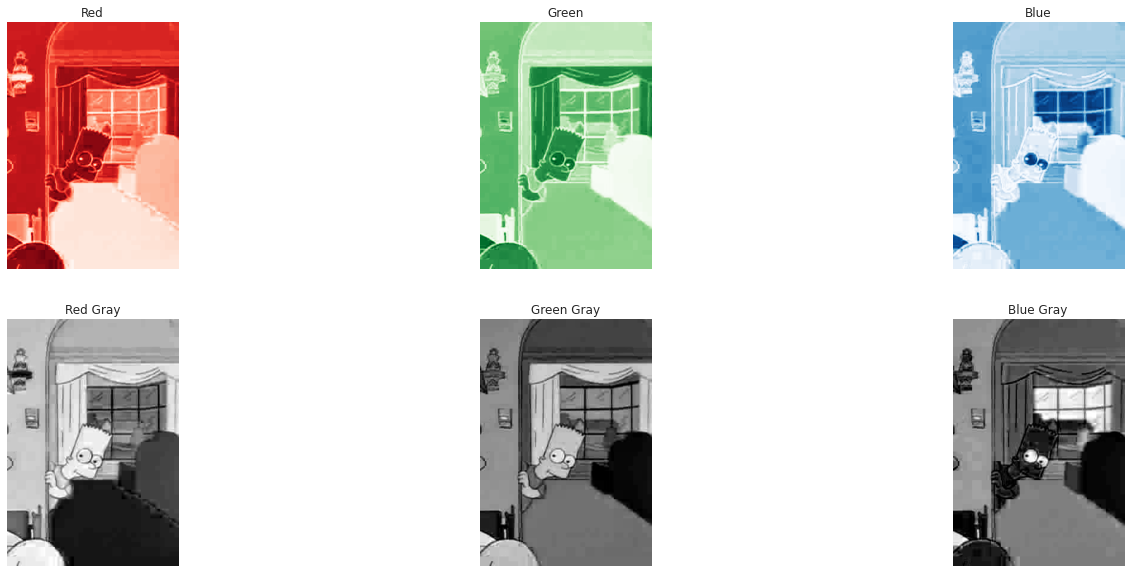

In [21]:
ROWS = 2
COLS = 3

pics = os.listdir(TRAINING_PATH + paths[0])
index = np.random.randint(len(pics))
camera = plt.imread(TRAINING_PATH + paths[0] + pics[index])

red = camera[:, :, 0]
green = camera[:, :, 1]
blue = camera[:, :, 2]

plt.figure(figsize=(2, 3))
plt.imshow(camera)
plt.axis('off')
plt.tight_layout()
plt.title('Imagen Original')

fig, ax = plt.subplots(2, 3, figsize = (24, 10))

ax[0][0].imshow(red, cmap='Reds')
ax[0][0].axis('off')
ax[0][0].set_title('Red')

ax[0][1].imshow(green, cmap='Greens')
ax[0][1].axis('off')
ax[0][1].set_title('Green')

ax[0][2].imshow(blue, cmap='Blues')
ax[0][2].axis('off')
ax[0][2].set_title('Blue')

ax[1][0].imshow(red, cmap='gray')
ax[1][0].axis('off')
ax[1][0].set_title('Red Gray')

ax[1][1].imshow(green, cmap='gray')
ax[1][1].axis('off')
ax[1][1].set_title('Green Gray')

ax[1][2].imshow(blue, cmap='gray')
ax[1][2].axis('off')
ax[1][2].set_title('Blue Gray')

plt.show()

# Preprocesamiento de las imagenes
Transformamos nuestras imagenes a 32 32 1

In [22]:
def load_image(filename, path,training = True):
    if (training):        
        inimg = tf.cast(tf.image.decode_image(tf.io.read_file(TRAINING_PATH + path + filename)), tf.float32)[..., :3]/255            
  
    else:
        inimg = tf.cast(tf.image.decode_image(tf.io.read_file(TEST_PATH + path + filename)), tf.float32)[..., :3]/255

    inimg = tf.image.resize(inimg, (32, 32))    
    inimg = color.rgb2gray(inimg)
    inimg = inimg[..., np.newaxis]

    return inimg

In [23]:
X_train = []
y_train = []

X_test = []
y_test = []

paths = ['bart_simpson/',
         'lenny_leonard/',
         'lisa_simpson/',
         'marge_simpson/',
         'maggie_simpson/',
         'milhouse_van_houten/',
         'moe_szyslak/',
         'nelson_muntz/',
         'comic_book_guy/',
         'otto_mann/',
         'disco_stu/',
         'apu_nahasapeemapetilon/',
         'abraham_grampa_simpson/']

# Training
for i in range(len(paths)):

    files = os.listdir(TRAINING_PATH + paths[i])

    for j in range(len(files)):
        X_train.append(load_image(files[j], paths[i]))
        
    y_train.extend(np.full(len(files), i))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_train, y_train = shuffle(X_train, y_train)

# Testing
for i in range(len(paths)):

    files = os.listdir(TEST_PATH + paths[i])

    for j in range(len(files)):
        X_test.append(load_image(files[j], paths[i], training = False))
  
    y_test.extend(np.full(len(files), i))

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_test, y_test = shuffle(X_test, y_test)

onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

In [24]:
data = {'shapes': [np.asarray(inp).shape for inp in X_test]}

df = pd.DataFrame(data)
df.value_counts()

shapes     
(32, 32, 1)    1394
dtype: int64

In [25]:
class DNN_model(object):
    def __init__(self, n_classes=13):
        
        self.h1LW = tf.Variable(np.random.rand(7, 7, 1, 32) * 0.1,
                               name = 'hl1weights',
                               dtype = 'float32')
        
        self.h1LB = tf.Variable(np.random.rand(32) * 0.1,
                               name = 'hl1bias',
                               dtype = 'float32')
                
        self.h2LW = tf.Variable(np.random.rand(5, 5, 32, 32) * 0.1,
                               name = 'hl2weights',
                               dtype = 'float32')
        
        self.h2LB = tf.Variable(np.random.rand(32) * 0.1,
                               name = 'hl2bias',
                               dtype = 'float32')                
        
        self.h3LW = tf.Variable(np.random.rand(3, 3, 32, 16) * 0.1,
                               name = 'hl3weights',
                               dtype = 'float32')
        
        self.h3LB = tf.Variable(np.random.rand(16) * 0.1,
                               name = 'hl3bias',
                               dtype = 'float32')
        
        self.h4LW = tf.Variable(np.random.rand(16, 16) * 0.1,
                               name = 'hl4weights',
                               dtype = 'float32')
        
        self.h4LB = tf.Variable(np.random.rand(16) * 0.1,
                               name = 'hl4bias',
                               dtype = 'float32')                
        
        self.outW = tf.Variable(np.random.rand(16, n_classes) * 0.1,
                                name="outweigths",
                                dtype="float32")
        
        self.outB = tf.Variable(np.random.rand(n_classes) * 0.1,
                                name="outbias",
                                dtype="float32")
        
        self.trainable_variables =[self.h1LW,self.h1LB,
                                   self.h2LW,self.h2LB,
                                   self.h3LW,self.h3LB,
                                   self.h4LW,self.h4LB,
                                   self.outW,self.outB]
        
    def __call__(self,x):
        
        x  = tf.cast(x, tf.float32)
        img = tf.reshape(x, shape = [-1, 32, 32, 1])
        
        l1 = tf.nn.conv2d(img, self.h1LW, strides = [1, 2, 2, 1], padding = 'SAME')        
        l1 = tf.add(l1, self.h1LB)
        l1 = tf.nn.relu(l1)
        l1 = tf.nn.max_pool(l1, ksize = [1, 2, 2, 1], padding = 'SAME', strides = [1, 2, 2, 1])        
        
        l2 = tf.nn.conv2d(l1, self.h2LW, strides = [1, 2, 2, 1], padding = 'SAME')        
        l2 = tf.add(l2, self.h2LB)
        l2 = tf.nn.relu(l2)
        l2 = tf.nn.max_pool(l2, ksize = [1, 2, 2, 1], padding = 'SAME', strides = [1, 2, 2, 1])
        l2 = tf.nn.dropout(l2, 0.12)
        
        l3 = tf.nn.conv2d(l2, self.h3LW, strides = [1, 2, 2, 1], padding = 'SAME')        
        l3 = tf.add(l3, self.h3LB)
        l3 = tf.nn.leaky_relu(l3)        
                
        l4 = tf.reshape(l3, [-1, 16])
        l4 = tf.matmul(l4, self.h4LW)
        l4 = tf.add(l4, self.h4LB)
        l4 = tf.nn.relu(l4)
        
        output = tf.matmul(l4, self.outW) + self.outB

        return output

In [26]:
model = DNN_model()
model(X_train[:30])

<tf.Tensor: shape=(30, 13), dtype=float32, numpy=
array([[227.89944 , 211.88469 , 210.71454 , 240.75801 , 196.20561 ,
        157.60414 , 244.44107 , 243.80647 , 172.10303 , 178.65065 ,
        217.41856 , 211.908   , 169.16165 ],
       [213.8798  , 199.1544  , 197.88495 , 226.44797 , 184.35638 ,
        148.07214 , 229.36533 , 228.85925 , 161.71004 , 167.71982 ,
        204.43094 , 198.9838  , 158.89833 ],
       [387.60675 , 361.13678 , 358.89584 , 410.38226 , 334.1419  ,
        268.39578 , 415.7775  , 414.78677 , 293.01    , 304.1728  ,
        370.47235 , 360.7911  , 287.9774  ],
       [411.562   , 382.87347 , 380.78827 , 434.9996  , 354.3736  ,
        284.74295 , 441.2018  , 440.26907 , 310.9047  , 322.6746  ,
        392.86948 , 382.7261  , 305.55917 ],
       [195.8177  , 182.21718 , 181.23058 , 207.18787 , 168.74174 ,
        135.51407 , 209.97441 , 209.62215 , 148.0688  , 153.55383 ,
        186.95331 , 182.1565  , 145.45215 ],
       [233.32175 , 216.90314 , 215.67104 , 2

In [27]:
optimizador = tf.keras.optimizers.Adam(learning_rate = 0.00025)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [28]:
@tf.function
def train_step(model,tdata, labels):
    with tf.GradientTape() as tape:
        predictions = model(tdata)
        #calculo de una funcion de error
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
   
    gradients = tape.gradient(loss, model.trainable_variables)
    capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
    optimizador.apply_gradients(capped_grads_and_vars)
    train_loss(loss)
    train_accuracy(labels, predictions)

In [29]:
@tf.function
def test_step(model, tdata, labels):
    predictions = model(tdata)
    t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [30]:
def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,N_batch,batch_size):
    for epoch in range(EPOCHS):
        i = 0
        while i + batch_size < len(train_x) or i + batch_size < batch_size * N_batch:
            start = i
            end = i + batch_size
            batch_x = train_x[start:end]
            batch_y = train_y[start:end]
            train_step(model,batch_x,batch_y)
            i += batch_size

        test_step(model,test_x,test_y)
        
        template = '----------------------------------------------\nEpoch: {}\nPerdida: {}\nExactitud: {}\nPerdida de prueba: {}\nExactitud de prueba: {}\n----------------------------------------------\n'
        
        print(template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result()*100,
                              test_loss.result(),
                              test_accuracy.result()*100))
        
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

In [31]:
fitting(model, X_train, y_train_onehot, X_test, y_test_onehot, 1000, 95, 94)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
----------------------------------------------
Epoch: 376
Perdida: 1.0145312547683716
Exactitud: 65.76225280761719
Perdida de prueba: 2.3316242694854736
Exactitud de prueba: 54.94978332519531
----------------------------------------------

----------------------------------------------
Epoch: 377
Perdida: 1.0113722085952759
Exactitud: 66.19168853759766
Perdida de prueba: 2.4303135871887207
Exactitud de prueba: 52.86943817138672
----------------------------------------------

----------------------------------------------
Epoch: 378
Perdida: 1.0231468677520752
Exactitud: 65.38160705566406
Perdida de prueba: 2.0796284675598145
Exactitud de prueba: 55.451934814453125
----------------------------------------------

----------------------------------------------
Epoch: 379
Perdida: 1.0163218975067139
Exactitud: 66.2112045288086
Perdida de prueba: 2.5509188175201416
Exactitud de prueba: 50.71736145019531
---------------------